In [10]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [4]:
pip install tensorflow

  Using cached tensorflow-2.15.0-cp310-cp310-win_amd64.whl.metadata (3.6 kB)
  Using cached tensorflow_intel-2.15.0-cp310-cp310-win_amd64.whl.metadata (5.1 kB)
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp310-cp310-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-16.0.6-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-4.25.1-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.14.1-cp310-cp310-win_amd64.whl (35 kB)
  Using cached tensorflow_io_gcs_filesystem-0

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'e:\\Resemblyzer-master\\venv\\Lib\\site-packages\\keras\\api\\_v1\\keras\\datasets\\imdb\\__init__.py'
Consider using the `--user` option or check the permissions.



In [11]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

In [12]:
dataset_root = r"E:\desktop files\new dataset\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "valid")

In [13]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.


In [14]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())

In [15]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 17572 images belonging to 38 classes.


In [16]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

In [17]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 38)                48678     
                                                                 
Total params: 2306662 (8.80 MB)
Trainable params: 48678 (190.

In [18]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [18]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

# Train the model for a specific number of epochs
num_epochs = 1  # Adjust this to the desired number of total epochs
history = model.fit(train_data, epochs=num_epochs, callbacks=[early_stopping_cb])





2197/2197 [==============================] - 4209s 2s/step - loss: 0.5695 - accuracy: 0.8319


In [19]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [20]:
model.evaluate(test_data)



550/550 [==============================] - 859s 2s/step - loss: 4.1761 - accuracy: 0.0361


[4.176083087921143, 0.03608012571930885]

In [26]:
model.save("updated_plant_disease_detection.h5")

e:\Resemblyzer-master\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
pip install seaborn

   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   -------- ------------------------------- 61.4/294.6 kB 1.7 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.6 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Found 17572 images belonging to 38 classes.
550/550 [==============================] - 1938s 3s/step


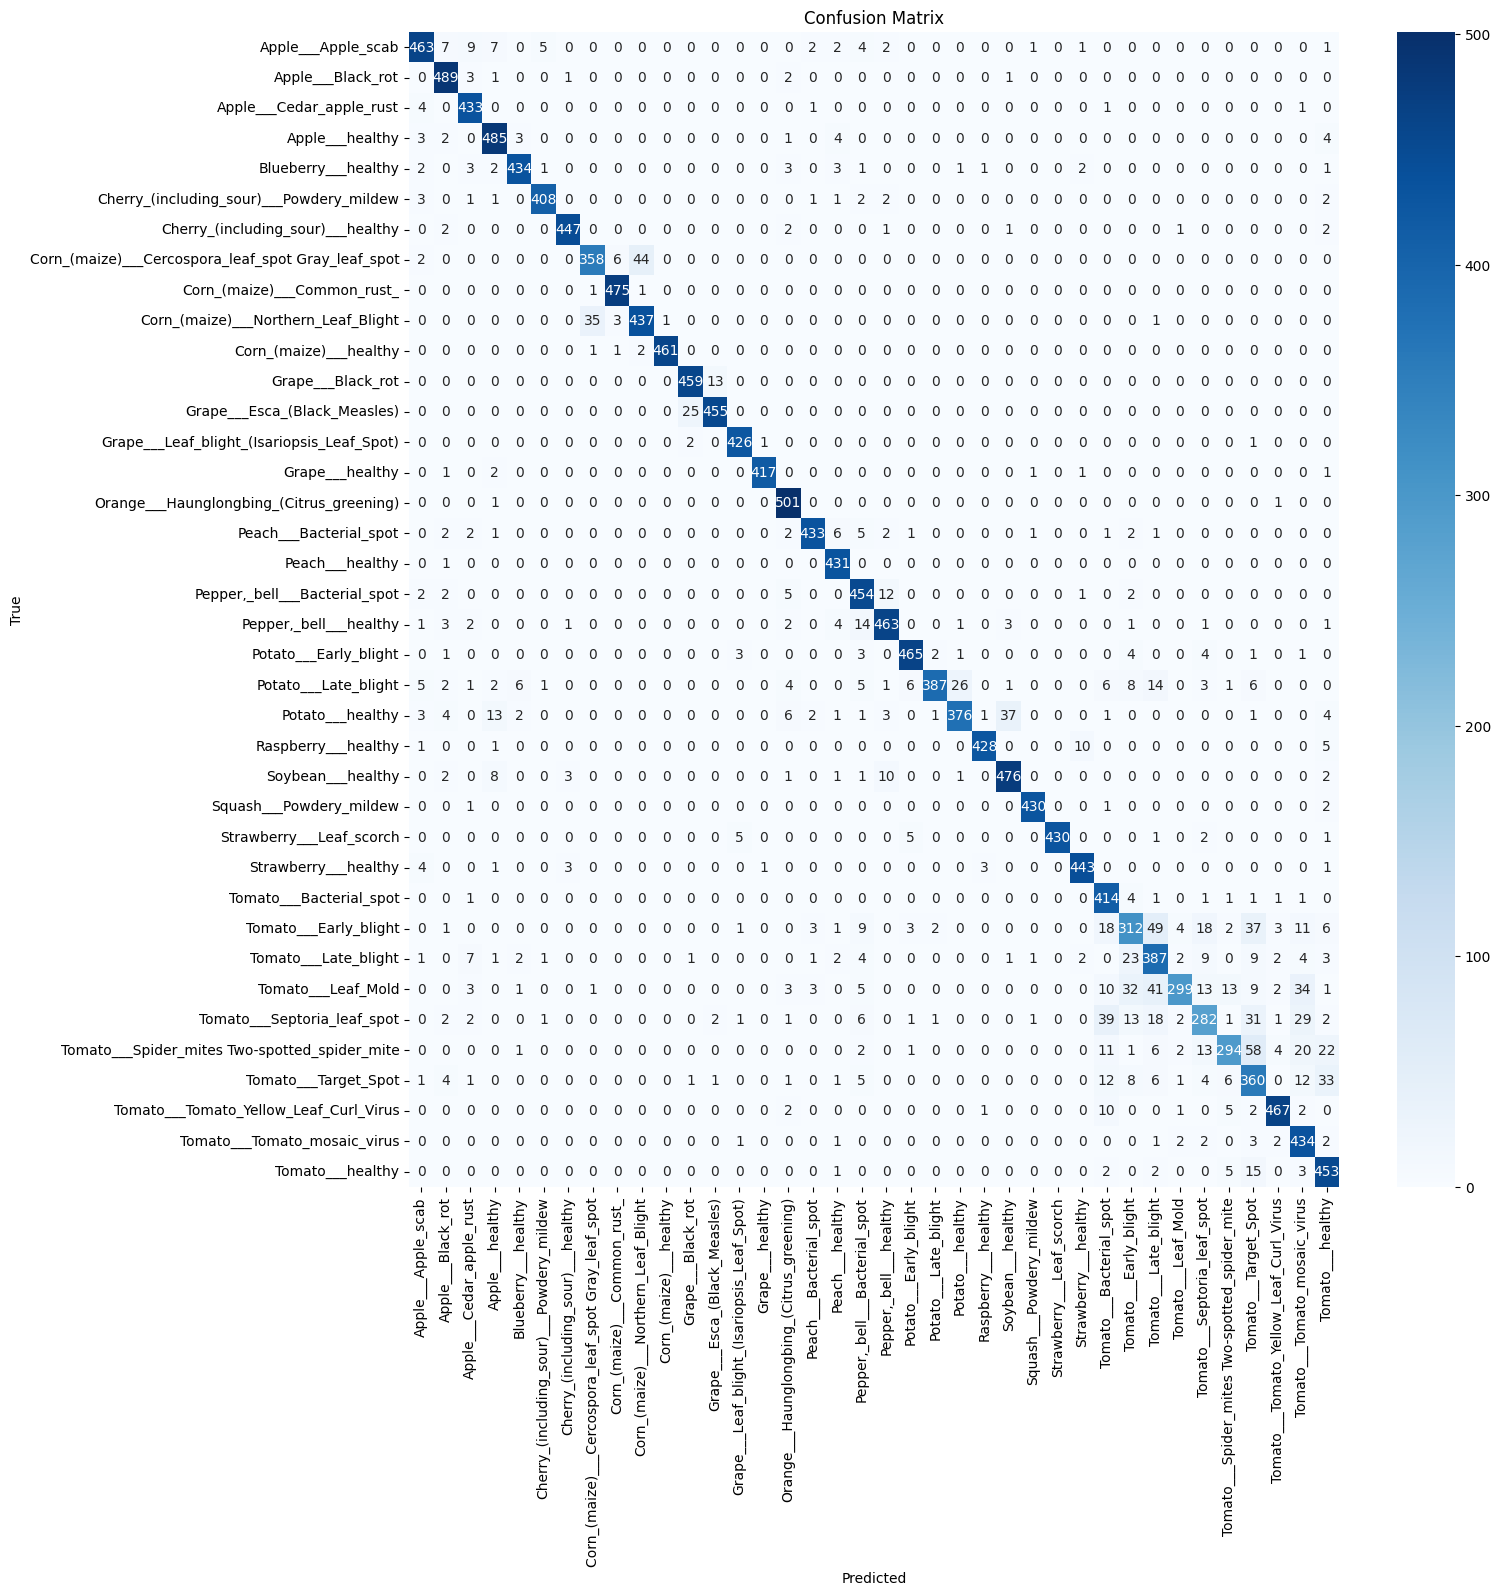

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.92      0.93       504
                                 Apple___Black_rot       0.93      0.98      0.96       497
                          Apple___Cedar_apple_rust       0.92      0.98      0.95       440
                                   Apple___healthy       0.92      0.97      0.94       502
                               Blueberry___healthy       0.97      0.96      0.96       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.97      0.97       421
                 Cherry_(including_sour)___healthy       0.98      0.98      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.87      0.89       410
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       477
               Corn_(maize)___Northern_Leaf_Blight      

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have a directory structure for your test data
test_data_dir = r'E:\desktop files\new dataset\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid'
target_size = (224, 224)  # Adjust based on your model's input size
batch_size = 32  # Adjust based on your preferences

# Set up the ImageDataGenerator for test data
test_data_generator = ImageDataGenerator(rescale=1/255.0)  # You may need to apply the same preprocessing as in training

# Generate batches of test data
test_data_flow = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",  # Adjust based on your data
    shuffle=False  # Set to False to keep the order of predictions in sync with true labels
)

# Get the true labels
true_labels = test_data_flow.classes

# Use the model to predict the labels for the test data
predicted_labels = model.predict(test_data_flow)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data_flow.class_indices, yticklabels=test_data_flow.class_indices)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=test_data_flow.class_indices.keys()))


In [14]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./new_plant_disease_detection.h5")

C:\Users\ZAHID HAMID WANI\Desktop\new dataset\new_plant_disease_detection.h5

Found 17572 images belonging to 38 classes.
550/550 [==============================] - 984s 2s/step


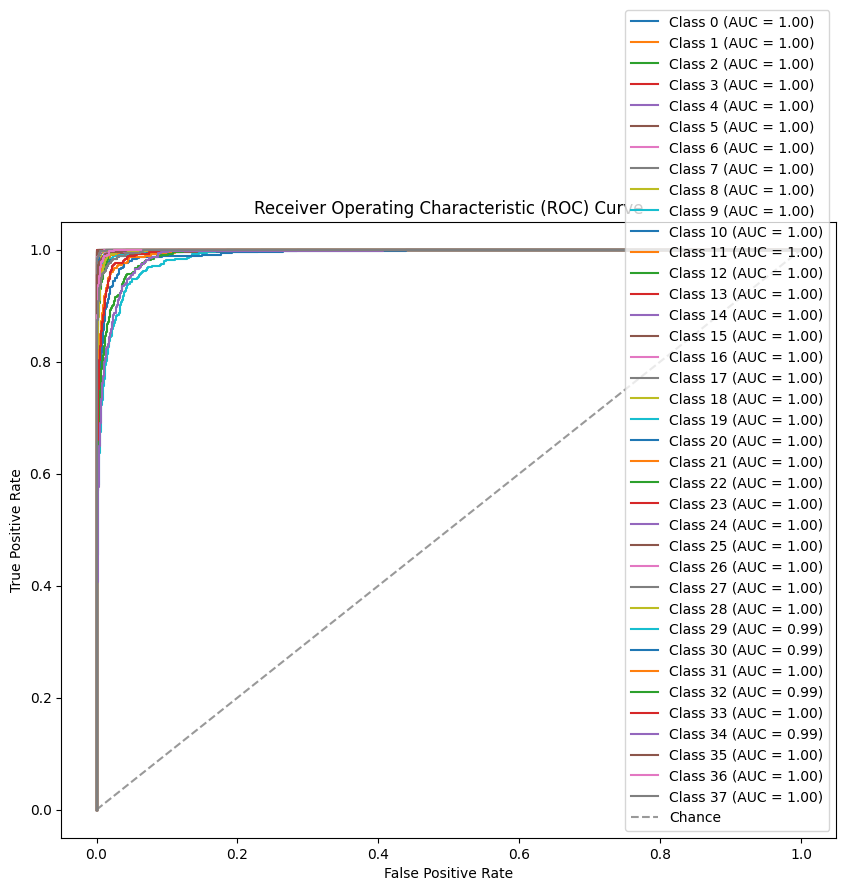

In [20]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have a directory structure for your test data
test_data_dir = r'E:\desktop files\new dataset\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid'
target_size = (224, 224)  # Adjust based on your model's input size
batch_size = 32  # Adjust based on your preferences

# Set up the ImageDataGenerator for test data
test_data_generator = ImageDataGenerator(rescale=1/255.0)  # You may need to apply the same preprocessing as in training

# Generate batches of test data
test_data_flow = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",  # Adjust based on your data
    shuffle=False  # Set to False to keep the order of predictions in sync with true labels
)

# Get the true labels
true_labels = test_data_flow.classes

# Use the model to predict the labels for the test data
predicted_labels = model.predict(test_data_flow)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_data_flow.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_labels[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(len(test_data_flow.class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
